In [53]:
import torch
import random
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
from inference_attack import *
from model import *
from numpy import argmax

In [54]:
# Configuration
model = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rng_seed = 0
dataset_name = "MNIST"                         # "MNIST" or "CIFAR10"
data_path = "./data"

# Part 1 Use pretrained model to create a dataset for gradient classification
pretrained_model_path = "trained_model_MNIST.pth"
criterion_pretrained_model = torch.nn.CrossEntropyLoss()
num_classes = 10
inference_dataset_size = 1500
batch_size_pretrained_model = 4

# Part 2 Train gradient classifier on gradient dataset
learning_rate_gradient_classifier = 0.001
criterion_grad_classifier = kl_div
train_size = 0.7
test_size = 1 - train_size
num_epochs = 15
batch_size_gradient_classifier = 16

# Part 3 Make inference on estimated gradient update
target_model_path = "GS_target_1.pth"
target_dataset_path = "target_1_dataset.pth"
learning_rate_pretrained_model = 0.01
num_clients_fl = 10

In [55]:
# Make reproducible
random.seed(rng_seed)
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)

## Part 1. Use pretrained model to create a dataset for gradient classification

In [56]:
# load dataset (we use test datasets to train the model on samples that have not been used in training of the global model)
if dataset_name == "MNIST":
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset = datasets.MNIST(root=data_path, train=False, download=True, transform=transform)
    input_shape = (1, 28, 28)

elif dataset_name == "CIFAR10":
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])
    dataset = datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
    input_shape = (3, 32, 32)

else:
    raise ValueError(f"Unsupported dataset: {dataset_name}")

indices = random.sample(range(len(dataset)), inference_dataset_size * batch_size_pretrained_model)
dataset = Subset(dataset, indices=indices)

dataloader = DataLoader(dataset, batch_size=batch_size_pretrained_model, shuffle=False)

In [57]:
# load pretrained model
theta_0 = torch.load(pretrained_model_path)

if model == 1:
    inference_model = Model1(input_shape, num_classes).to(device)
elif model == 2:
    inference_model = Model2(input_shape, num_classes).to(device)
else:
    print('Unknown model:', model)

inference_model.load_state_dict(state_dict=theta_0)

<All keys matched successfully>

In [58]:
# collect gradient features
features = []
labels = []

inference_model.to(device)
inference_model.train() # eval can make some layers behave differently (Not in our case)

for x, y in dataloader:
    x, y = x.to(device), y.to(device)

    # Forward pass
    output = inference_model(x)
    loss = criterion_pretrained_model(output, y)

    # Compute gradients w.r.t. model parameters (except fc)
    fc_params = set(p for p in inference_model.fc.parameters())
    all_params = list(inference_model.parameters())
    params_except_fc = [p for p in all_params if p not in fc_params]
    grad = torch.autograd.grad(loss, params_except_fc, retain_graph=False)
    # grad = torch.autograd.grad(loss, inference_model.parameters(), retain_graph=False)
    grad_vector = torch.cat([g.view(-1) for g in grad])  # Flatten and concatenate

    # Detach and store
    features.append(grad_vector.detach().cpu().float())
    labels.append(multi_hot_encode(y, num_classes))

features = torch.stack(features)
labels = torch.stack(labels).float()

dataset = TensorDataset(features, labels)
input_dim = features.shape[1]
output_dim = labels.shape[1]

In [59]:
temploader = DataLoader(dataset, batch_size=1, shuffle=True)
cnt = 0
for x, y in temploader:
    cnt += 1
print(cnt)

1500


In [60]:
# Dataset augmentation arbitrary scaling

## Part 2. Train gradient classifier on gradient dataset

In [61]:
# dataset split
tmp_train = int(train_size*inference_dataset_size)
tmp_test = inference_dataset_size - tmp_train
# tmp_test = int(inference_dataset_size/batch_size_pretrained_model-tmp_train)
print(tmp_train, tmp_test)

train_dataset, test_dataset = random_split(dataset, [tmp_train, tmp_test])

train_loader = DataLoader(train_dataset, batch_size=batch_size_gradient_classifier, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_gradient_classifier)

1050 450


In [62]:
# Model training
grad_classifier_model = GradientClassifier(input_dim=input_dim, output_dim=output_dim)
grad_classifier_model.to(device)

hist_train_acc, hist_test_acc, hist_train_loss, hist_test_loss = train_grad_classifier(grad_classifier_model, train_loader, test_loader, criterion_grad_classifier, batch_size_pretrained_model, num_epochs=num_epochs, lr=learning_rate_gradient_classifier, device=device)

Epoch 1/15 | Loss: 1.0118 | Accuracy: 0.41
Test Loss: 0.9347 | Cosine Similarity: 0.6675, Test Accuracy: 0.4739
Epoch 2/15 | Loss: 0.9213 | Accuracy: 0.53
Test Loss: 0.9273 | Cosine Similarity: 0.6703, Test Accuracy: 0.4650
Epoch 3/15 | Loss: 0.9181 | Accuracy: 0.48
Test Loss: 0.9260 | Cosine Similarity: 0.6810, Test Accuracy: 0.4706
Epoch 4/15 | Loss: 0.9166 | Accuracy: 0.51
Test Loss: 0.9252 | Cosine Similarity: 0.6887, Test Accuracy: 0.4744
Epoch 5/15 | Loss: 0.9146 | Accuracy: 0.52
Test Loss: 0.9233 | Cosine Similarity: 0.6983, Test Accuracy: 0.5500
Epoch 6/15 | Loss: 0.9123 | Accuracy: 0.54
Test Loss: 0.9198 | Cosine Similarity: 0.7247, Test Accuracy: 0.5794
Epoch 7/15 | Loss: 0.9097 | Accuracy: 0.56
Test Loss: 0.9171 | Cosine Similarity: 0.7468, Test Accuracy: 0.5339
Epoch 8/15 | Loss: 0.9071 | Accuracy: 0.57
Test Loss: 0.9152 | Cosine Similarity: 0.7606, Test Accuracy: 0.5350
Epoch 9/15 | Loss: 0.9040 | Accuracy: 0.58
Test Loss: 0.9122 | Cosine Similarity: 0.7860, Test Accuracy:

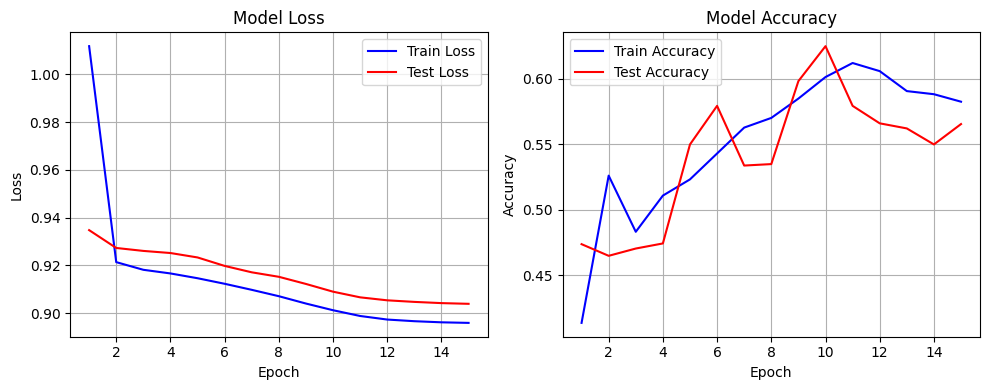

In [63]:
epcs = range(1, num_epochs + 1)

# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 2)
plt.plot(epcs, hist_train_acc, 'b-', label='Train Accuracy')
plt.plot(epcs, hist_test_acc, 'r-', label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epcs, hist_train_loss, 'b-', label='Train Loss')
plt.plot(epcs, hist_test_loss, 'r-', label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [64]:
# Model evaluation
test_preds, acc, avg_loss = evaluate_model(grad_classifier_model, test_loader, criterion_grad_classifier, batch_size_pretrained_model, device)

Test Loss: 0.9039 | Cosine Similarity: 0.8597, Test Accuracy: 0.5656


## Part 3. Make inference on estimated gradient update

In [65]:
# load true gradient update
true_grad = torch.load('DEBUG_true_grads.pth')
# remove fc layer
true_grad = remove_layers(true_grad, ['fc.weight', 'fc.bias'])

In [66]:
# Estimate gradient update
theta_0 = torch.load(pretrained_model_path)
theta_1 = torch.load(target_model_path)
# remove fc layer
theta_0 = remove_layers(theta_0, ['fc.weight', 'fc.bias'])
theta_1 = remove_layers(theta_1, ['fc.weight', 'fc.bias'])
# 
theta_1 = state_dict_scale(theta_1, num_clients_fl)
est_grad = estimate_gradient(theta_0, theta_1, learning_rate_pretrained_model)

cs = state_dicts_average_cosine_similarity(est_grad, true_grad)
mse = state_dicts_mse(est_grad, true_grad)
print(f'cosine similarity between estimated gradient and true gradient: {cs:.4f}')
print(f'mse between estimated gradient and true gradient: {mse:.4f}')

cosine similarity between estimated gradient and true gradient: 1.0000
mse between estimated gradient and true gradient: 0.0000


[0.00013709929771721363, 2.47226871579187e-05, 0.0004421982739586383, 0.0002030285249929875, 1.5170052165558445e-06, 9.467606787438854e-07, 0.000394952337956056, 0.4720093607902527, 0.22601601481437683, 0.300770103931427]


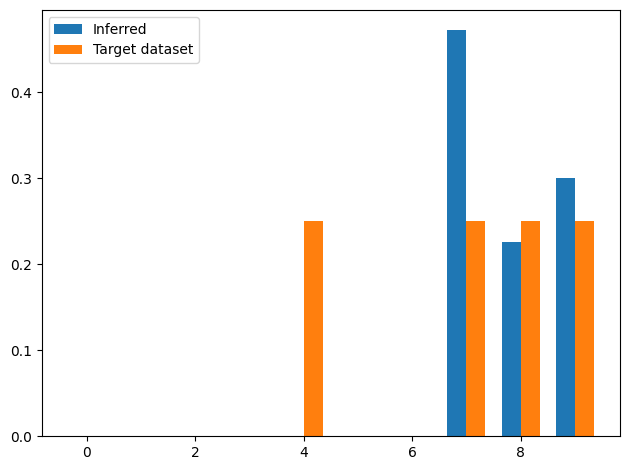

In [67]:
# Inference
est_grad_vector = torch.cat([est_grad[key].view(-1) for key in est_grad.keys()]).unsqueeze(0)
inferred = grad_classifier_model(est_grad_vector)
inferred = inferred.tolist()[0]
print(inferred)

target_dataset = torch.load(target_dataset_path)
target_dataset = target_dataset["dataset"]
target_label = [0 for i in range(num_classes)]
den = len(target_dataset)
for idx in target_dataset:
    target_label[idx] = 1 / den

bar_width = 0.35
x = np.arange(num_classes)

plt.bar(x - bar_width/2, inferred, width=bar_width, label='Inferred')
plt.bar(x + bar_width/2, target_label, width=bar_width, label='Target dataset')
plt.legend()

plt.tight_layout()
plt.show()

In [68]:
inferred = prob_to_prediction(torch.Tensor(inferred), batch_size_pretrained_model)
print('True dataset:    ', target_dataset)
print('Inferred dataset:', inferred)

True dataset:     [8, 7, 4, 9]
Inferred dataset: [2, 7, 8, 9]
